<a href="https://colab.research.google.com/github/juliuswiscmsba/Flu-Shot-Learning/blob/main/H1N1_Flu_Vaccines_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score, roc_curve

Load Dataset

In [ ]:
from google.colab import files
train_features = files.upload()
train_labels = files.upload()
test_features = files.upload()

Saving training_set_features.csv to training_set_features (1).csv


Saving training_set_labels.csv to training_set_labels (1).csv


Saving test_set_features.csv to test_set_features (1).csv


In [ ]:
train_feature = pd.read_csv('training_set_features.csv')
train_label = pd.read_csv('training_set_labels.csv')
test = pd.read_csv('test_set_features.csv')

In [ ]:
train = train_feature.merge(train_label, how='inner',on='respondent_id')
train.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


EDA

In [ ]:
len(train)

26707

In [ ]:
train.isna().sum()

respondent_id                      0
h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
m

In [ ]:
train.dtypes

respondent_id                    int64
h1n1_concern                   float64
h1n1_knowledge                 float64
behavioral_antiviral_meds      float64
behavioral_avoidance           float64
behavioral_face_mask           float64
behavioral_wash_hands          float64
behavioral_large_gatherings    float64
behavioral_outside_home        float64
behavioral_touch_face          float64
doctor_recc_h1n1               float64
doctor_recc_seasonal           float64
chronic_med_condition          float64
child_under_6_months           float64
health_worker                  float64
health_insurance               float64
opinion_h1n1_vacc_effective    float64
opinion_h1n1_risk              float64
opinion_h1n1_sick_from_vacc    float64
opinion_seas_vacc_effective    float64
opinion_seas_risk              float64
opinion_seas_sick_from_vacc    float64
age_group                       object
education                       object
race                            object
sex                      

In [ ]:
oj_list=[]
cat_list=[]
for i in train.columns:
    if train[i].dtype == object:
        oj_list.append(i)
        train[i] = train[i].fillna('Unknown')
    elif i != 'respondent_id':
        cat_list.append(i)
        train[i] = train[i].fillna(-1)

In [ ]:
for j in test.columns:
    if test[j].dtype == object:
        test[j] = test[j].fillna('Unknown')
    else:
        test[j] = test[j].fillna(-1)

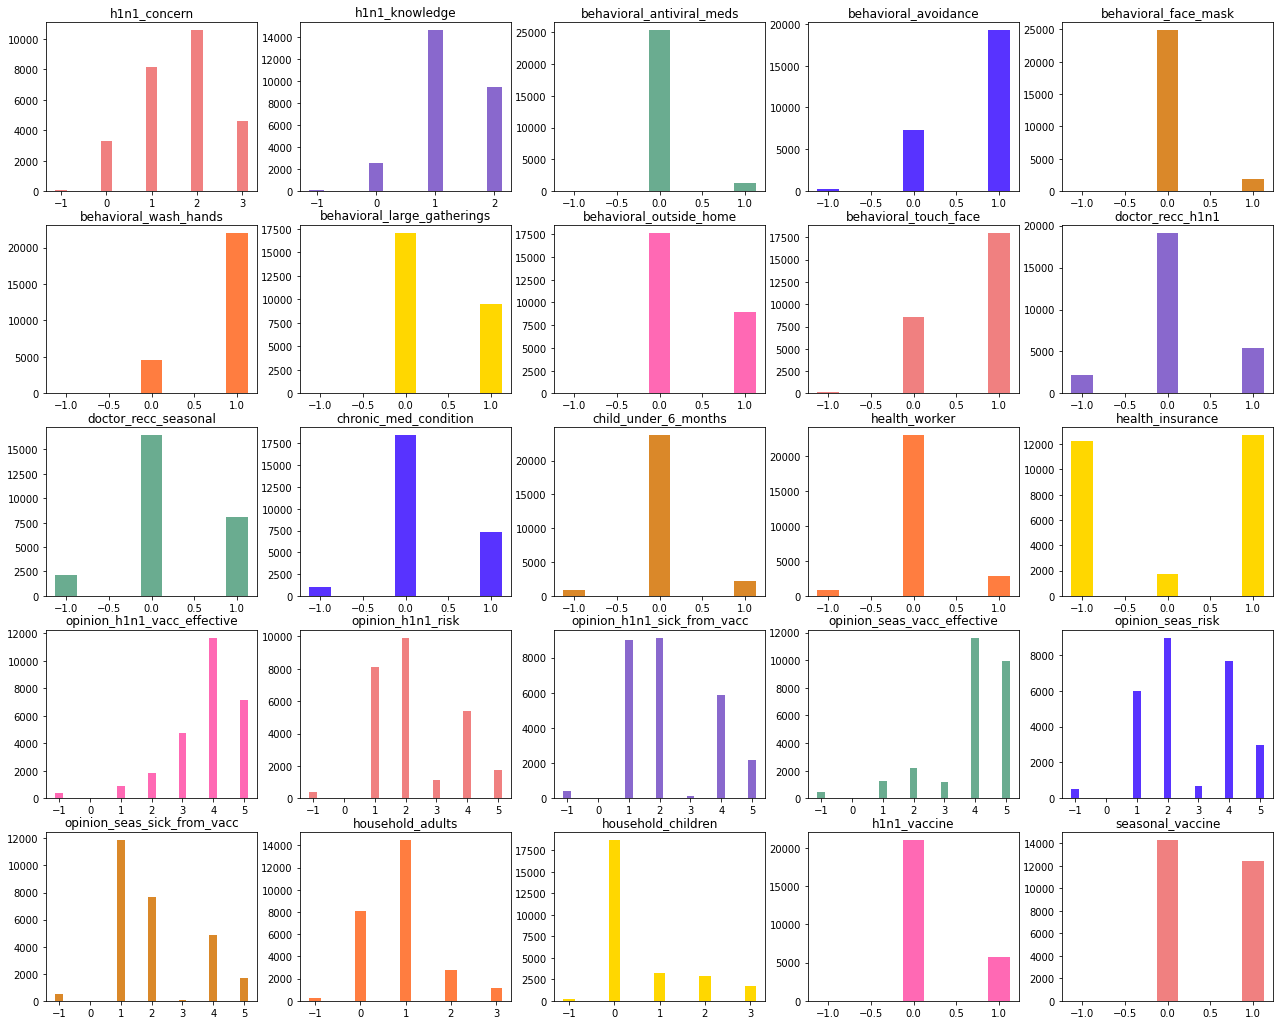

In [ ]:
#cat_cols visualization
nrows = 5
ncols = int(len(cat_list)/nrows)
color_list = ["#F08080","#8968CD","#6aac90","#5833ff","#da8829","#FF7D40","#FFD700","#FF69B4"]
fig, axes = plt.subplots(nrows, ncols, figsize = (22,18))
axes = axes.flatten()
for count, p in enumerate(cat_list):
    plt.sca(axes[count])
    plt.title(p)
    bins = np.arange(-1,max(train[p]+0.5),0.25)-0.125
    plt.hist(train[p], bins=bins, color=color_list[count%len(color_list)])

Some Quick Observation:

    a. In the health_insurance column, the proportion of missing values is huge.
    b. Respondents are more willing to take the seasonal vaccine than the h1n1 vaccine.
    c. Most respondents do not take antiviral medications before.
    d. Most respondents do not have children.
    e. Most respondents in this dataset wash their hands but do not wear a face mask.
    f. Most respondents in this dataset are not health-related workers
    g. Most respondents in this dataset think the h1n1 vaccine does have a somewhat or great effect on h1n1. 
    h. Most respondents think the risk of getting sick with H1N1 flu without a vaccine is low.
    i. Most respondents think the seasonal flu vaccine does have a somewhat or great effect on flu.
    j. Different from (h), Only half of the respondents think the risk of getting sick with seasonal flu without a vaccine is low.
    k. Most respondents do not think they will get sick after taking the vaccine. In other words, those who took the vaccine believed in it.

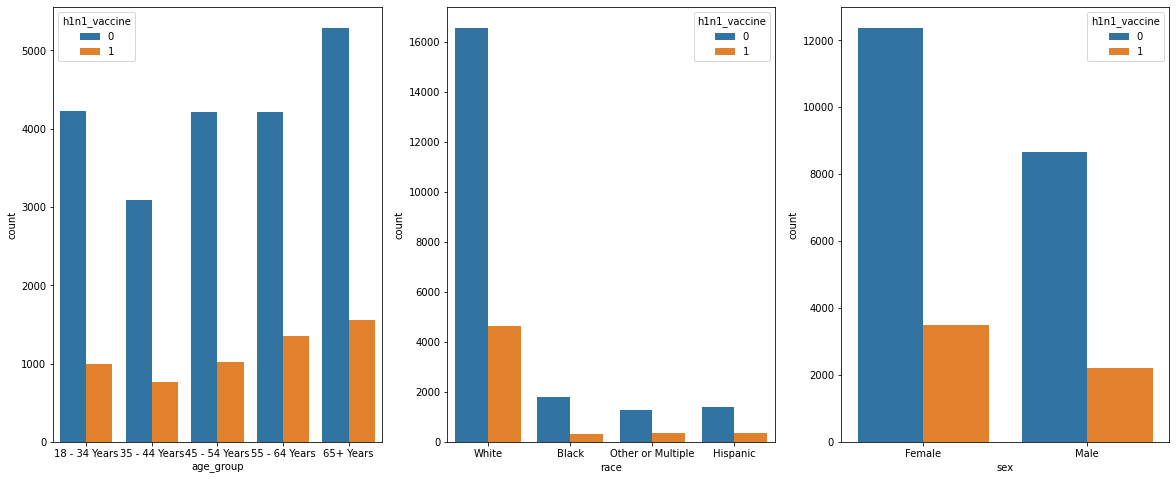

In [ ]:
#Interested in age_group, race, and sex to vaccines.
fig, axes = plt.subplots(1, 3, figsize = (20,8))
sns.countplot(x='age_group', hue='h1n1_vaccine', data = train, order=['18 - 34 Years','35 - 44 Years','45 - 54 Years','55 - 64 Years','65+ Years'],ax=axes[0])
sns.countplot(x='race', hue='h1n1_vaccine', data = train,ax=axes[1])
sns.countplot(x='sex', hue='h1n1_vaccine', data = train,ax=axes[2])

Age_group:

    a. 65+ group is slightly more than the other groups. 
    b. 35-44 group is slightly less than the other group. 
    c. Age above 55 years seems more prefer to take the h1n1 vaccine.
    

Race:
    
    a. Most respondents in this dataset are white and extremely imbalanced.

Sex:
    
    a. Female is slightly more than male in this dataset. 
    b. However there is no big difference in h1n1 vaccine proportion.

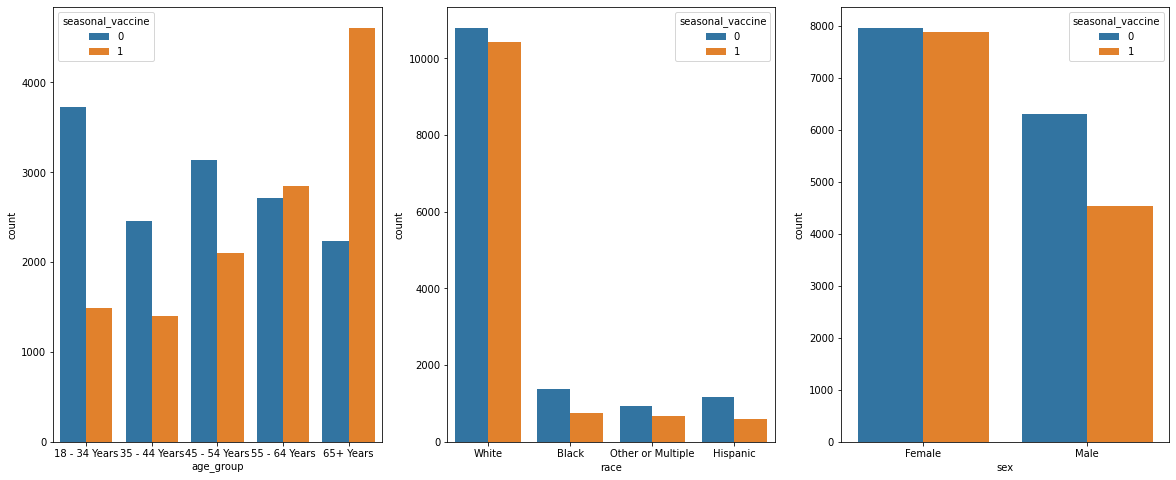

In [ ]:
fig, axes = plt.subplots(1, 3, figsize = (20,8))
sns.countplot(x='age_group', hue='seasonal_vaccine', data = train, order=['18 - 34 Years','35 - 44 Years','45 - 54 Years','55 - 64 Years','65+ Years'],ax=axes[0])
sns.countplot(x='race', hue='seasonal_vaccine', data = train,ax=axes[1])
sns.countplot(x='sex', hue='seasonal_vaccine', data = train,ax=axes[2])

Age_group:

    a. There are more and more respondents taking a seasonal vaccine as their age increases.
    b. More than half of the respondents whose age is above 55 took the seasonal vaccine.
    c. Respondents are more willing to take the seasonal vaccine than the h1n1 vaccine in each age group.

Race:
    
    a. Most respondents in this dataset are white and extremely imbalanced.
    b. Respondents are more willing to take the seasonal vaccine than the h1n1 vaccine no matter their race.

Sex:
    
    a. Females are more willing to take the seasonal vaccine.
    b. Respondents are more willing to take the seasonal vaccine than the h1n1 vaccine no matter their sex.

Prepare the data for our model.

In [ ]:
for i in oj_list:
    le = LabelEncoder()
    train[i]=le.fit_transform(train[i])
    test[i]=le.fit_transform(test[i])

In [ ]:
for i in train.columns:
    train[i] = train[i].astype(int)

In [ ]:
for j in test.columns:
    test[j] = test[j].astype(int)

In [ ]:
X = train.drop(['respondent_id','h1n1_vaccine','seasonal_vaccine'],axis=1)
y1 = train['h1n1_vaccine']
y2 = train['seasonal_vaccine']

In [ ]:
X_train, X_test, y1_train, y1_test, y2_train, y2_test = train_test_split(X, y1, y2, test_size=0.2, random_state = 42)
X_train, X_val, y1_train, y1_val, y2_train, y2_val = train_test_split(X_train, y1_train, y2_train, test_size=0.1, random_state = 42)

Modeling(catboost model + gridsearch)

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from catboost import CatBoostClassifier, Pool

cat_model = CatBoostClassifier()

params = {'iterations': [400, 600, 1000],
        'learning_rate': [0.1, 0.05, 0.01],
        'max_depth': [4, 6],
        'l2_leaf_reg': [0.1, 0.5, 1, 3],
        'verbose':[10],
        'random_seed': [42],
        'loss_function':['Logloss'],
        'eval_metric':['AUC:hints=skip_train~false']}

scorer = make_scorer(roc_auc_score)

cat_grid = GridSearchCV(estimator=cat_model, param_grid=params, scoring=scorer, cv=5)

In [ ]:
cat_grid.fit(X_train, y1_train, eval_set=(X_val,y1_val))
best_param_h1n1 = cat_grid.best_params_
best_param_h1n1

串流輸出內容已截斷至最後 5000 行。
780:	learn: 0.9133755	test: 0.8713383	best: 0.8714044 (707)	total: 5.07s	remaining: 1.42s
790:	learn: 0.9138358	test: 0.8715035	best: 0.8715035 (790)	total: 5.14s	remaining: 1.36s
800:	learn: 0.9142707	test: 0.8713129	best: 0.8715035 (790)	total: 5.2s	remaining: 1.29s
810:	learn: 0.9146792	test: 0.8712951	best: 0.8715035 (790)	total: 5.26s	remaining: 1.23s
820:	learn: 0.9151561	test: 0.8711579	best: 0.8715035 (790)	total: 5.33s	remaining: 1.16s
830:	learn: 0.9155698	test: 0.8712367	best: 0.8715035 (790)	total: 5.4s	remaining: 1.1s
840:	learn: 0.9159659	test: 0.8711732	best: 0.8715035 (790)	total: 5.46s	remaining: 1.03s
850:	learn: 0.9163048	test: 0.8710207	best: 0.8715035 (790)	total: 5.52s	remaining: 967ms
860:	learn: 0.9166378	test: 0.8709521	best: 0.8715035 (790)	total: 5.58s	remaining: 901ms
870:	learn: 0.9171072	test: 0.8710321	best: 0.8715035 (790)	total: 5.65s	remaining: 837ms
880:	learn: 0.9174895	test: 0.8710969	best: 0.8715035 (790)	total: 5.71s	remaining

{'eval_metric': 'AUC:hints=skip_train~false',
 'iterations': 1000,
 'l2_leaf_reg': 0.5,
 'learning_rate': 0.05,
 'loss_function': 'Logloss',
 'max_depth': 4,
 'random_seed': 42,
 'verbose': 10}

In [ ]:
h1n1_model = CatBoostClassifier(iterations=best_param_h1n1['iterations'], 
                                learning_rate=best_param_h1n1['learning_rate'], 
                                max_depth=best_param_h1n1['max_depth'],
                                l2_leaf_reg=best_param_h1n1['l2_leaf_reg'],
                                verbose=10,
                                cat_features=X_train.columns.to_list(),
                                early_stopping_rounds=200,
                                loss_function='Logloss',
                                eval_metric='AUC:hints=skip_train~false')

In [ ]:
h1n1_model.fit(X_train, y1_train, eval_set=(X_val,y1_val),verbose=10,use_best_model = True,plot = True)
preds_proba_h1n1 = h1n1_model.predict_proba(X_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8062182	test: 0.8015359	best: 0.8015359 (0)	total: 99.7ms	remaining: 1m 39s
10:	learn: 0.8407653	test: 0.8394429	best: 0.8394429 (10)	total: 1.24s	remaining: 1m 51s
20:	learn: 0.8445409	test: 0.8425493	best: 0.8426256 (19)	total: 2.22s	remaining: 1m 43s
30:	learn: 0.8493589	test: 0.8469549	best: 0.8472192 (29)	total: 3.9s	remaining: 2m 2s
40:	learn: 0.8525966	test: 0.8493931	best: 0.8493931 (40)	total: 5.63s	remaining: 2m 11s
50:	learn: 0.8553146	test: 0.8526787	best: 0.8526787 (50)	total: 7.4s	remaining: 2m 17s
60:	learn: 0.8570956	test: 0.8546639	best: 0.8546639 (60)	total: 9.06s	remaining: 2m 19s
70:	learn: 0.8589123	test: 0.8566173	best: 0.8566173 (70)	total: 10.8s	remaining: 2m 21s
80:	learn: 0.8604577	test: 0.8579711	best: 0.8579711 (80)	total: 12.6s	remaining: 2m 23s
90:	learn: 0.8618883	test: 0.8588897	best: 0.8588897 (90)	total: 14.4s	remaining: 2m 23s
100:	learn: 0.8630936	test: 0.8601297	best: 0.8601551 (99)	total: 16.3s	remaining: 2m 25s
110:	learn: 0.8643954	te

In [ ]:
h1n1_proba = preds_proba_h1n1[:,1].reshape(-1,1)

In [ ]:
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(
        f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}"
    )

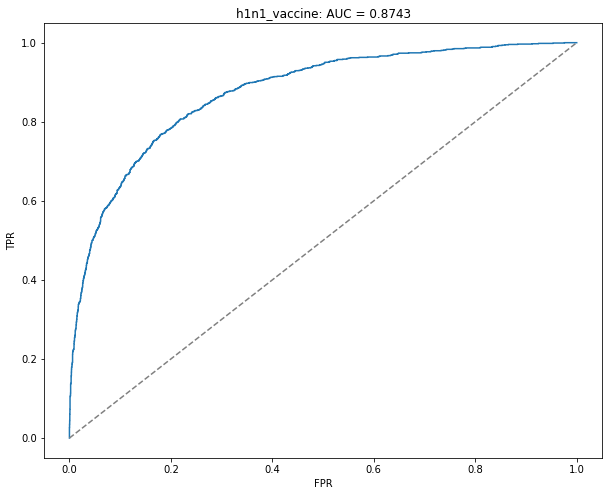

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_roc(
    y1_test, 
    h1n1_proba, 
    'h1n1_vaccine',
    ax=ax
)

In [ ]:
cat_grid.fit(X_train, y2_train, eval_set=(X_val,y2_val),verbose=10,use_best_model = True,plot = True)
best_param_sea = cat_grid.best_params_
best_param_sea

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 41.6ms	remaining: 16.6s
10:	learn: 0.8356444	test: 0.8387179	best: 0.8387179 (10)	total: 378ms	remaining: 13.4s
20:	learn: 0.8439849	test: 0.8457268	best: 0.8457268 (20)	total: 745ms	remaining: 13.4s
30:	learn: 0.8497160	test: 0.8514228	best: 0.8514228 (30)	total: 847ms	remaining: 10.1s
40:	learn: 0.8529636	test: 0.8545610	best: 0.8545610 (40)	total: 907ms	remaining: 7.94s
50:	learn: 0.8566441	test: 0.8566253	best: 0.8566253 (50)	total: 990ms	remaining: 6.77s
60:	learn: 0.8582912	test: 0.8579466	best: 0.8579466 (60)	total: 1.05s	remaining: 5.84s
70:	learn: 0.8601807	test: 0.8585231	best: 0.8586646 (66)	total: 1.12s	remaining: 5.19s
80:	learn: 0.8617316	test: 0.8587885	best: 0.8587885 (80)	total: 1.19s	remaining: 4.68s
90:	learn: 0.8632727	test: 0.8594151	best: 0.8594151 (90)	total: 1.28s	remaining: 4.34s
100:	learn: 0.8652127	test: 0.8597894	best: 0.8599599 (96)	total: 1.57s	remaining: 4.65s
110:	learn: 0.8667168	test: 0.86

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 6.28ms	remaining: 2.51s
10:	learn: 0.8343184	test: 0.8354685	best: 0.8354685 (10)	total: 68.6ms	remaining: 2.42s
20:	learn: 0.8467083	test: 0.8457501	best: 0.8457501 (20)	total: 140ms	remaining: 2.52s
30:	learn: 0.8517919	test: 0.8504926	best: 0.8504926 (30)	total: 207ms	remaining: 2.47s
40:	learn: 0.8556118	test: 0.8543022	best: 0.8543022 (40)	total: 272ms	remaining: 2.38s
50:	learn: 0.8583291	test: 0.8554692	best: 0.8555193 (48)	total: 334ms	remaining: 2.28s
60:	learn: 0.8602647	test: 0.8565528	best: 0.8565528 (60)	total: 417ms	remaining: 2.31s
70:	learn: 0.8622063	test: 0.8568419	best: 0.8568419 (70)	total: 485ms	remaining: 2.25s
80:	learn: 0.8643673	test: 0.8579044	best: 0.8579167 (78)	total: 550ms	remaining: 2.17s
90:	learn: 0.8658355	test: 0.8584765	best: 0.8584765 (90)	total: 613ms	remaining: 2.08s
100:	learn: 0.8674572	test: 0.8589440	best: 0.8589440 (100)	total: 683ms	remaining: 2.02s
110:	learn: 0.8689890	test: 0.

In [68]:
sea_model = CatBoostClassifier(iterations=best_param_sea['iterations'], 
                                learning_rate=best_param_sea['learning_rate'], 
                                max_depth=best_param_sea['max_depth'],
                                l2_leaf_reg=best_param_sea['l2_leaf_reg'],
                                verbose=10,
                                cat_features=X_train.columns.to_list(),
                                early_stopping_rounds=200,
                                loss_function='Logloss',
                                eval_metric='AUC:hints=skip_train~false')

In [69]:
sea_model.fit(X_train, y2_train, eval_set=(X_val,y2_val),verbose=10,use_best_model = True,plot = True)
preds_proba_sea = sea_model.predict_proba(X_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8239836	test: 0.8266638	best: 0.8266638 (0)	total: 156ms	remaining: 1m 2s
10:	learn: 0.8394027	test: 0.8409668	best: 0.8409668 (10)	total: 1.49s	remaining: 52.7s
20:	learn: 0.8472007	test: 0.8468820	best: 0.8468820 (20)	total: 2.88s	remaining: 51.9s
30:	learn: 0.8528450	test: 0.8501002	best: 0.8501002 (30)	total: 4.26s	remaining: 50.7s
40:	learn: 0.8567512	test: 0.8523389	best: 0.8523389 (40)	total: 5.68s	remaining: 49.7s
50:	learn: 0.8598319	test: 0.8547394	best: 0.8547394 (50)	total: 7.14s	remaining: 48.8s
60:	learn: 0.8625855	test: 0.8563722	best: 0.8563722 (60)	total: 8.55s	remaining: 47.5s
70:	learn: 0.8645017	test: 0.8575674	best: 0.8575674 (70)	total: 9.94s	remaining: 46s
80:	learn: 0.8662678	test: 0.8582366	best: 0.8582366 (80)	total: 11.4s	remaining: 44.9s
90:	learn: 0.8678391	test: 0.8588790	best: 0.8588790 (90)	total: 12.8s	remaining: 43.4s
100:	learn: 0.8691823	test: 0.8594379	best: 0.8594511 (98)	total: 14.2s	remaining: 42s
110:	learn: 0.8705502	test: 0.8596963

In [70]:
sea_proba = preds_proba_sea[:,1].reshape(-1,1)

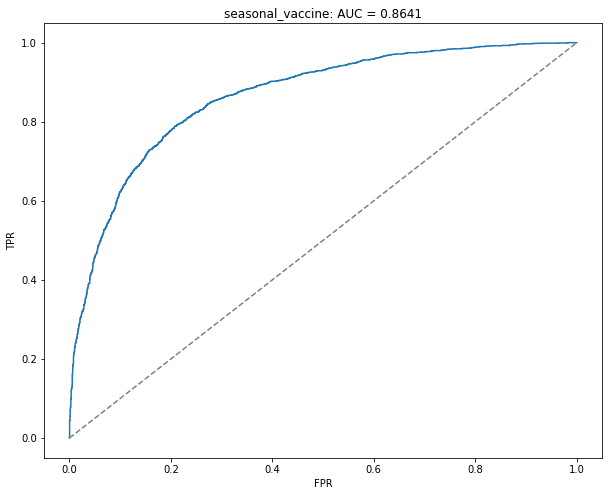

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_roc(
    y2_test, 
    sea_proba, 
    'seasonal_vaccine',
    ax=ax
)

In [72]:
tt = test.drop('respondent_id',axis=1)
test['h1n1_vaccine'] = h1n1_model.predict_proba(tt)[:,1]
test['seasonal_vaccine'] = sea_model.predict_proba(tt)[:,1]

In [ ]:
sub = test[['respondent_id','h1n1_vaccine','seasonal_vaccine']].set_index('respondent_id')
sub.to_csv('submission.csv')

In [ ]:
sub

In [ ]:
files.download('submission.csv')

Analyze the catboost models

In [94]:
import shap
shap.initjs()

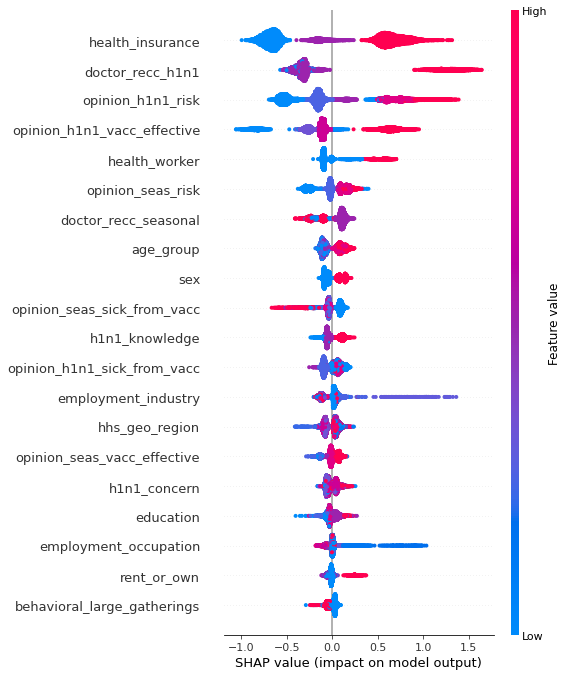

In [67]:
# summarize the effects of all the features to h1n1 vaccine prediction
shap.summary_plot(shap_values_h1n1, X_train)

Top 5 features in the h1n1 catboost model:
    
    a. Whether respondent has health insurance or not.
    b. Whether the h1n1 vaccine was recommended by doctor or not.
    c. Respondent's opinion about risk of getting sick with h1n1 without vaccine.
    d. Respondent's opinion about h1n1 vaccine effectiveness.
    e. Whether the seasonal flu vaccine was recommended by doctor or not.

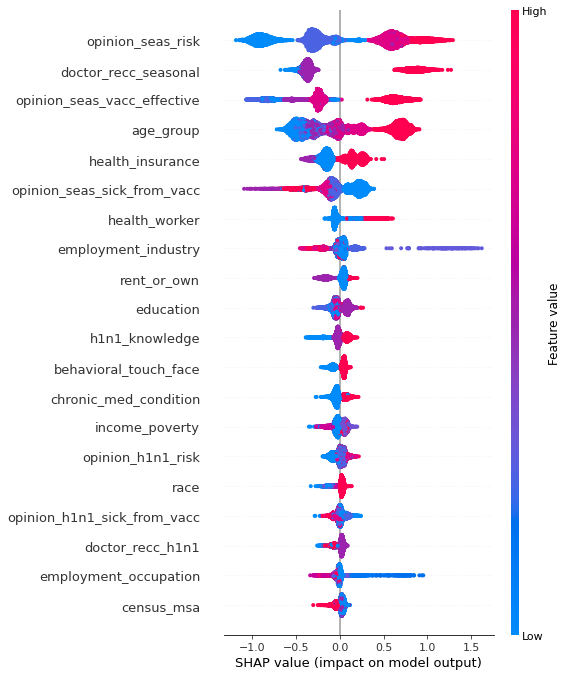

In [66]:
# summarize the effects of all the features to seasonal flu vaccine prediction
shap.summary_plot(shap_values_sea, X_train)

Top 5 features in the seasonal flu catboost model:
    
    a. Whether the seasonal flu vaccine was recommended by doctor or not.
    b. Respondent's opinion about risk of getting sick with seasonal flu without vaccine
    c. Respondent's opinion about seasonal flu vaccine effectiveness.
    d. Age.
    e. Whether respondent has health insurance or not.